In [3]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import yfinance as yf

# Load stock data
symbol = 'SPXL'  # Using QQQ as an example

# Fetching the data
ticker = yf.Ticker(symbol)
df = ticker.history(period="5y")

# Calculate Exponential Moving Averages
short_window = 26
long_window = 60
take_profit_pct = 20  # 10%
stop_loss_pct = 0.05  # -5%

# Convert percentages to actual price changes relative to the entry price
take_profit = df['Close'] * take_profit_pct
stop_loss = df['Close'] * stop_loss_pct

df['hlc3'] = (df['High'] + df['Low'] + df['Close']) / 3
df['short_ma'] = df['hlc3'].rolling(3).mean().shift(1)
# df['short_ma'] = df['Close'].ewm(span=short_window, adjust=False).mean()
# df['long_ma'] = df['hlc3'].rolling(60).mean().shift(1)
df['long_ma'] = df['Close'].ewm(span=long_window, adjust=False).mean()

# Generate crossover signals
df['short_ma_prev'] = df['short_ma'].shift(1)
df['long_ma_prev'] = df['long_ma'].shift(1)

# Entry signal for long positions: short MA crosses above long MA
df['long_entry'] = ((df['short_ma'] > df['long_ma']) & 
                    (df['short_ma_prev'] <= df['long_ma_prev'])).astype(bool)

# Entry signal for short positions: short MA crosses below long MA (previously exit_signal)
df['short_entry'] = ((df['short_ma'] < df['long_ma']) & 
                     (df['short_ma_prev'] >= df['long_ma_prev'])).astype(bool)

# Exit signals can be the inverse of entry signals or defined based on other logic
df['long_exit'] = df['short_entry']  # Exiting long positions when we enter short positions
df['short_exit'] = df['long_entry']  # Exiting short positions when we enter long positions

# Backtest with vectorbt, specifying short entries and exits
pf = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['long_entry'],
    exits=df['long_exit'],
    # short_entries=df['short_entry'],
    # short_exits=df['short_exit'],
    size=np.inf,
    sl_stop=stop_loss_pct,
    tp_stop=take_profit_pct,
    freq='1D'
)

# Plot cumulative returns
# pf.cumulative_returns().vbt.plot().show()
pf.plot(subplots=['cum_returns','trades']).show()

# Show performance metrics
print(pf.stats())


Start                         2019-03-28 00:00:00-04:00
End                           2024-03-27 00:00:00-04:00
Period                               1259 days 00:00:00
Start Value                                       100.0
End Value                                    242.082407
Total Return [%]                             142.082407
Benchmark Return [%]                         201.876415
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              39.044865
Max Drawdown Duration                 619 days 00:00:00
Total Trades                                         19
Total Closed Trades                                  18
Total Open Trades                                     1
Open Trade PnL                                94.938737
Win Rate [%]                                  33.333333
Best Trade [%]                                92.806969
Worst Trade [%]                               -9

# Screenshot of chart for reference
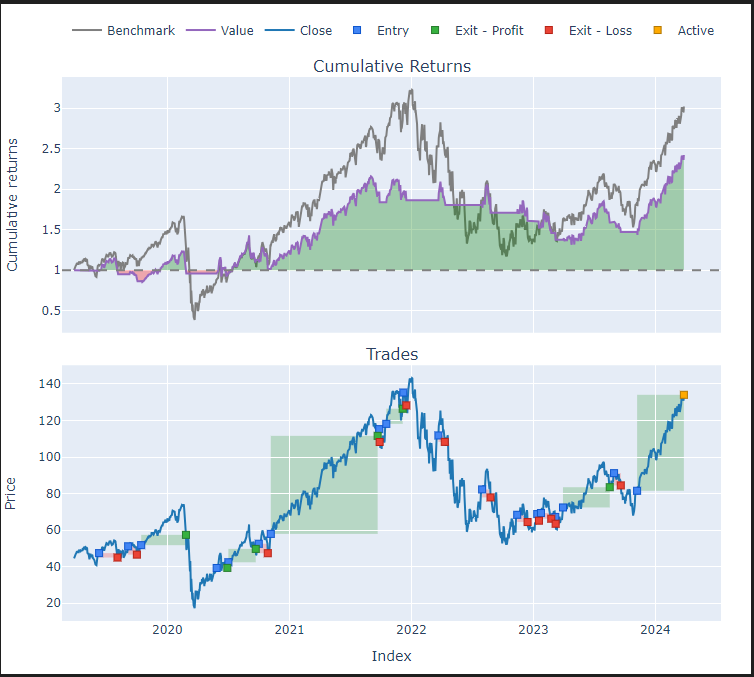

In [4]:
pf.total_return()

1.4208240703059292

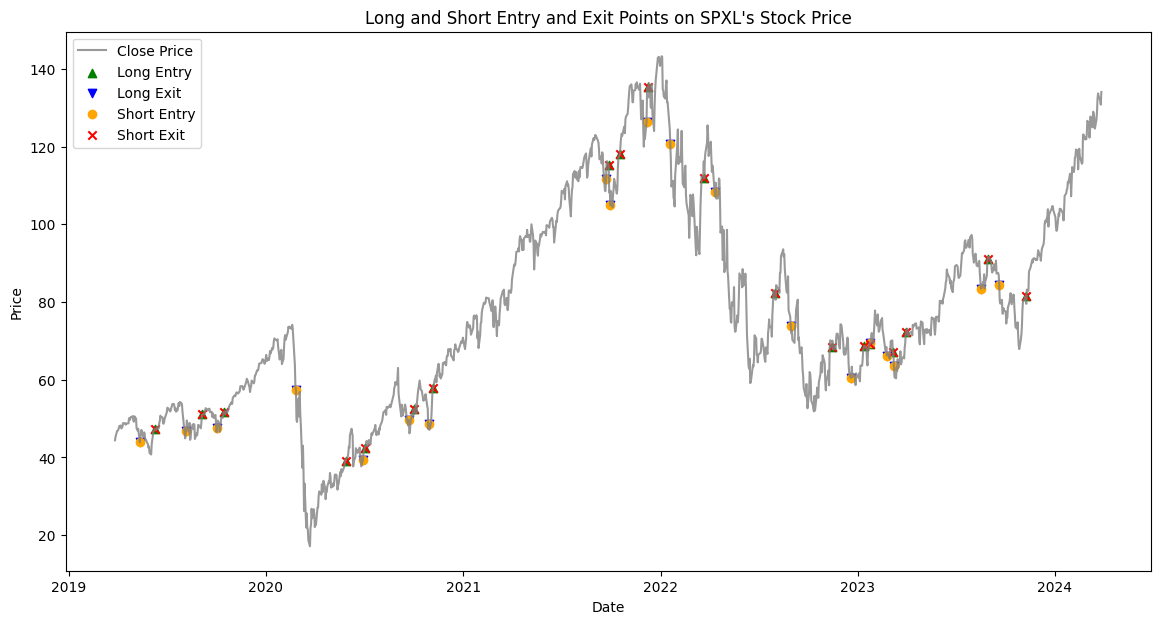

In [5]:
import matplotlib.pyplot as plt

# Assuming 'df' and 'pf' are already defined as per your previous code

# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='gray', alpha=0.8)

# Highlight long entry points
long_entry_points = df[df['long_entry']].index
plt.scatter(long_entry_points, df.loc[long_entry_points, 'Close'], color='green', label='Long Entry', marker='^', alpha=1)

# Highlight long exit points
long_exit_points = df[df['long_exit']].index
plt.scatter(long_exit_points, df.loc[long_exit_points, 'Close'], color='blue', label='Long Exit', marker='v', alpha=1)

# Highlight short entry points
short_entry_points = df[df['short_entry']].index
plt.scatter(short_entry_points, df.loc[short_entry_points, 'Close'], color='orange', label='Short Entry', marker='o', alpha=1)

# Highlight short exit points
short_exit_points = df[df['short_exit']].index
plt.scatter(short_exit_points, df.loc[short_exit_points, 'Close'], color='red', label='Short Exit', marker='x', alpha=1)

plt.title(f"Long and Short Entry and Exit Points on {symbol}'s Stock Price")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
